# Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications import VGG16
from keras.models import load_model
from keras.layers import Input, Dense
from keras import layers
import glob
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os
# for dirname, _, filenames in os.walk('/Users/eric/Desktop/gramaco_capstone/all_slabs/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


# Loding Data

In [2]:
# creating image size variable
img_size = 224

# creating batch size variable
batch = 32

In [3]:
# setting earlystopping
early = EarlyStopping(monitor = 'val_loss',
              mode = 'min',
              patience = 3, 
              restore_best_weights = True)

# setting modelcheckpoint
check = ModelCheckpoint('./m_checkpoint',
               monitor = 'val_loss',
               save_best_only = True,
               mode = 'min')

# creating list for callbacks
call_list = [early, check]

In [4]:
# loading data from directory
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range = 20,
        validation_split = .3,
        horizontal_flip=True)

train_generator = datagen.flow_from_directory(
        '/Users/eric/Desktop/gramaco_capstone/all_slabs/',
        subset = 'training',
        target_size=(img_size, img_size),
        batch_size=batch,
        color_mode = 'rgb',
        class_mode= None)

validation_generator = datagen.flow_from_directory(
        '/Users/eric/Desktop/gramaco_capstone/all_slabs/',
        subset = 'validation',
        target_size=(img_size, img_size),
        batch_size=batch,
        class_mode= None)

Found 451 images belonging to 1 classes.
Found 192 images belonging to 1 classes.


# Modeling

In [5]:
# loading saved model
model = VGG16(weights = 'imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
# compiling model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],)

In [7]:
# checking summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
# # fitting model
# history = model.fit_generator(
#         train_generator,
#         steps_per_epoch=50,
#         epochs=12,
#         validation_data=validation_generator,
#         validation_steps=12,
#         workers = -1,
#         verbose = 1,
#         callbacks = call_list)

In [9]:
# evaluating model performance on 20 steps
# model.evaluate_generator(train_generator, steps = 20, workers = -1, verbose = 1)

In [10]:
# creating feature extractor
feat_extractor = Model(model.input, outputs=model.get_layer("fc2").output)

In [11]:
# getting summary of features
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
# evaluating model performance on 5 steps
# model.evaluate_generator(train_generator, steps = 5, workers = -1, verbose = 1)

# Building Recommender

number of products: 44


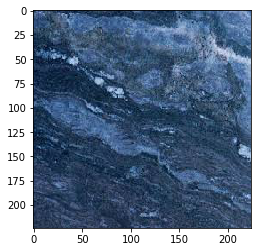

black galaxy 2.jpg'] loaded.


In [13]:
path = '/Users/eric/Desktop/gramaco_capstone/test_slabs/'

# Loading testing images to use for recommendations, filters by file type
products = [path + x for x in os.listdir(path) if "jpg" or "JPG" or 'png' or 'jpeg' in x]

# prints out number of product images
print("number of products:",len(products))

# load an image in Python Image Library (PIL) format
image = load_img(products[0], target_size=(img_size, img_size))

# plots images
plt.imshow(image)
plt.show()

# gets filename from path only
p_name = os.path.basename(str(products))

# prints out product image
print(f"{p_name} loaded.")

In [14]:
# load all the images and prepare them for feeding into the CNN
importedImages = [] # empyth list to append

for p in products: # loop to iterate through each product in file path
    filename = p
    original = load_img(filename, target_size=(img_size, img_size))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)

    importedImages.append(image_batch)

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

# extract the images features
imgs_features = feat_extractor.predict(processed_imgs)

In [15]:
# function to retrieve the most similar products for a given one
def recommender(product):

    # compute cosine similarities between images
    cosine = cosine_similarity(imgs_features)

    # creates a dataframe of the cosine similarites
    cosine_df = pd.DataFrame(cosine, columns=products, index=products)
    

    sim_images = 5
    
    p_name = os.path.basename(str(product))
    
    print("-----------------------------------------------------------------------")
    print(f"Selected {p_name}:")

    image = load_img(product, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.show()

    print("-----------------------------------------------------------------------")
    print(f"Recommended products based on {p_name}:")
    
    
    recommend_imgs = cosine_df[product].sort_values(ascending=False)[1:sim_images+1].index
    recommend_scores = cosine_df[product].sort_values(ascending=False)[1:sim_images+1]

    for i in range(0,len(recommend_imgs)):
        image = load_img(recommend_imgs[i], target_size=(img_size, img_size))
        plt.imshow(image)
        plt.show()
        rec_name = os.path.basename(str(recommend_imgs[i]))
        print(f"Recommended Product: {rec_name}")
        print(f"Recommendation Score: {recommend_scores[i]}")
        print("-----------------------------------------------------------------------")

# Recommender

-----------------------------------------------------------------------
Selected cosmic_black.jpg:


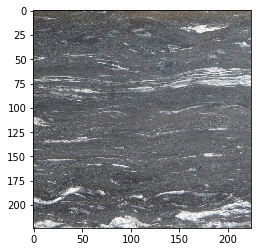

-----------------------------------------------------------------------
Recommended products based on cosmic_black.jpg:


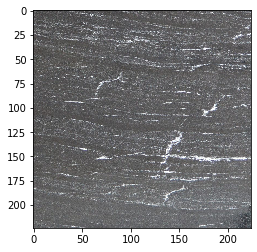

Recommended Product: black_ocean.jpg
Recommendation Score: 0.6763582825660706
-----------------------------------------------------------------------


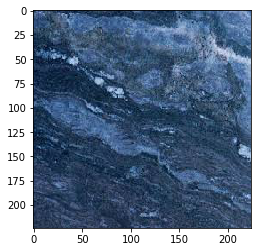

Recommended Product: granite_blue.jpeg
Recommendation Score: 0.6265032887458801
-----------------------------------------------------------------------


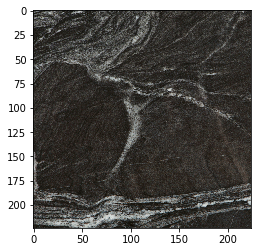

Recommended Product: blizzard.jpg
Recommendation Score: 0.5275670886039734
-----------------------------------------------------------------------


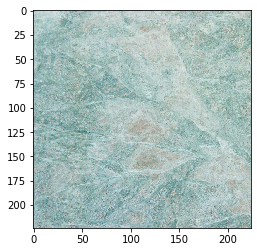

Recommended Product: caribbean_green.jpg
Recommendation Score: 0.5099413394927979
-----------------------------------------------------------------------


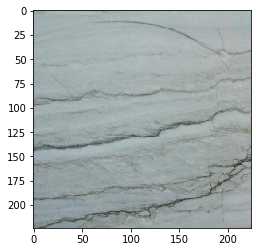

Recommended Product: white_macaubas.jpg
Recommendation Score: 0.4520263969898224
-----------------------------------------------------------------------


In [16]:
recommender(products[12])